In [1]:
import os
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import pickle
# import pyspark

# Data Preprocessing
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.decomposition import PCA


# ML Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier)
import scipy

# Performance metrics
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline


#yellowbrick

from yellowbrick.target import FeatureCorrelation
from yellowbrick.features import rank2d, RadViz, Rank2D
from yellowbrick.classifier import DiscriminationThreshold, PrecisionRecallCurve, ROCAUC
from yellowbrick.model_selection import feature_importances, CVScores, RFECV, FeatureImportances
from yellowbrick.model_selection import LearningCurve, ValidationCurve
from yellowbrick.classifier import ClassificationReport, ClassPredictionError, ConfusionMatrix
import warnings 
warnings.filterwarnings('ignore')

import missingno as msno

In [2]:
#Get Exo-Planet file and load it into pandas DataFrame
file_name = 'cumulative_2021'
input_dir = os.getcwd()
data_dir = os.path.join(input_dir,"data")
kep_file = os.path.join(data_dir, file_name + '.csv')
df = pd.read_csv(kep_file)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 49 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   kepid              9564 non-null   int64  
 1   kepoi_name         9564 non-null   object 
 2   kepler_name        2365 non-null   object 
 3   koi_disposition    9564 non-null   object 
 4   koi_pdisposition   9564 non-null   object 
 5   koi_score          8054 non-null   float64
 6   koi_fpflag_nt      9564 non-null   int64  
 7   koi_fpflag_ss      9564 non-null   int64  
 8   koi_fpflag_co      9564 non-null   int64  
 9   koi_fpflag_ec      9564 non-null   int64  
 10  koi_period         9564 non-null   float64
 11  koi_period_err1    9110 non-null   float64
 12  koi_period_err2    9110 non-null   float64
 13  koi_time0bk        9564 non-null   float64
 14  koi_time0bk_err1   9110 non-null   float64
 15  koi_time0bk_err2   9110 non-null   float64
 16  koi_impact         9201 

In [3]:
df.shape

(9564, 49)

In [4]:
df.head()

,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,0.000,0,0,0,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


### Selecting Columns for Prediction


   *We eliminate all the columns that are either of the following*

    [x]Assigned after other values are measured from readings
    
    [x]Contain ID or name attributes
    
    [x]Are error attributes



In [5]:
ALL_COLUMNS = df.columns
ERROR_COLUMNS = [col for col in ALL_COLUMNS if "err" in col]
EXCLUDE = ["rowid", "kepid", "kepoi_name","kepler_name","koi_score", "koi_disposition", "koi_pdisposition", "koi_tce_delivname", "koi_tce_plnt_num"] + ERROR_COLUMNS
TO_USE = list(set(ALL_COLUMNS) - set(EXCLUDE))

In [6]:
print(f"Columns being analysed: {len(TO_USE)}")
df[TO_USE].head()

Columns being analysed: 19


,koi_time0bk,koi_impact,koi_fpflag_ss,koi_fpflag_co,koi_kepmag,koi_fpflag_nt,koi_slogg,koi_prad,koi_model_snr,koi_steff,koi_srad,koi_depth,ra,koi_fpflag_ec,koi_teq,dec,koi_insol,koi_period,koi_duration
0,170.538750,0.146,0,0,15.347,0,4.467,2.26,35.8,5455.0,0.927,616.0,291.93423,0,793.0,48.141651,93.59,9.488036,2.95750
1,162.513840,0.586,0,0,15.347,0,4.467,2.83,25.8,5455.0,0.927,875.0,291.93423,0,443.0,48.141651,9.11,54.418383,4.50700
2,175.850252,0.969,0,0,15.436,0,4.544,14.60,76.3,5853.0,0.868,10800.0,297.00482,0,638.0,48.134129,39.30,19.899140,1.78220
3,170.307565,1.276,1,0,15.597,0,4.564,33.46,505.6,5805.0,0.791,8080.0,285.53461,0,1395.0,48.285210,891.96,1.736952,2.40641
4,171.595550,0.701,0,0,15.509,0,4.438,2.75,40.9,6031.0,1.046,603.0,288.75488,0,1406.0,48.226200,926.16,2.525592,1.65450



### Extracting Dataframe Subset

We extract only those rows which are either positive or negative examples i.e. the disposition value is not CANDIDATE.
This is because CANDIDATE is the default value for all obects of interest picked up by Kepler. The labels CONFIRMED and FALSE POSITIVE serve as our positive and negative labels
Difference between disposition and pdisposition?

We can use either of the two columns as our target variable, since both of them contain the target labels we desire. While pdisposition gives us the most probable labels based on the physical explanation given by the readings, disposition values are based on the NASA Exoplanet Archive Data.


In [7]:
np.unique(df["koi_disposition"].values)

array(['CANDIDATE', 'CONFIRMED', 'FALSE POSITIVE'], dtype=object)

In [8]:
subset_df = df[df["koi_disposition"] != "CANDIDATE"]
print(subset_df.shape)

subset_df.head()

(7203, 49)


,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
3,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
5,10872983,K00756.01,Kepler-228 d,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-232.0,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714


<AxesSubplot:>

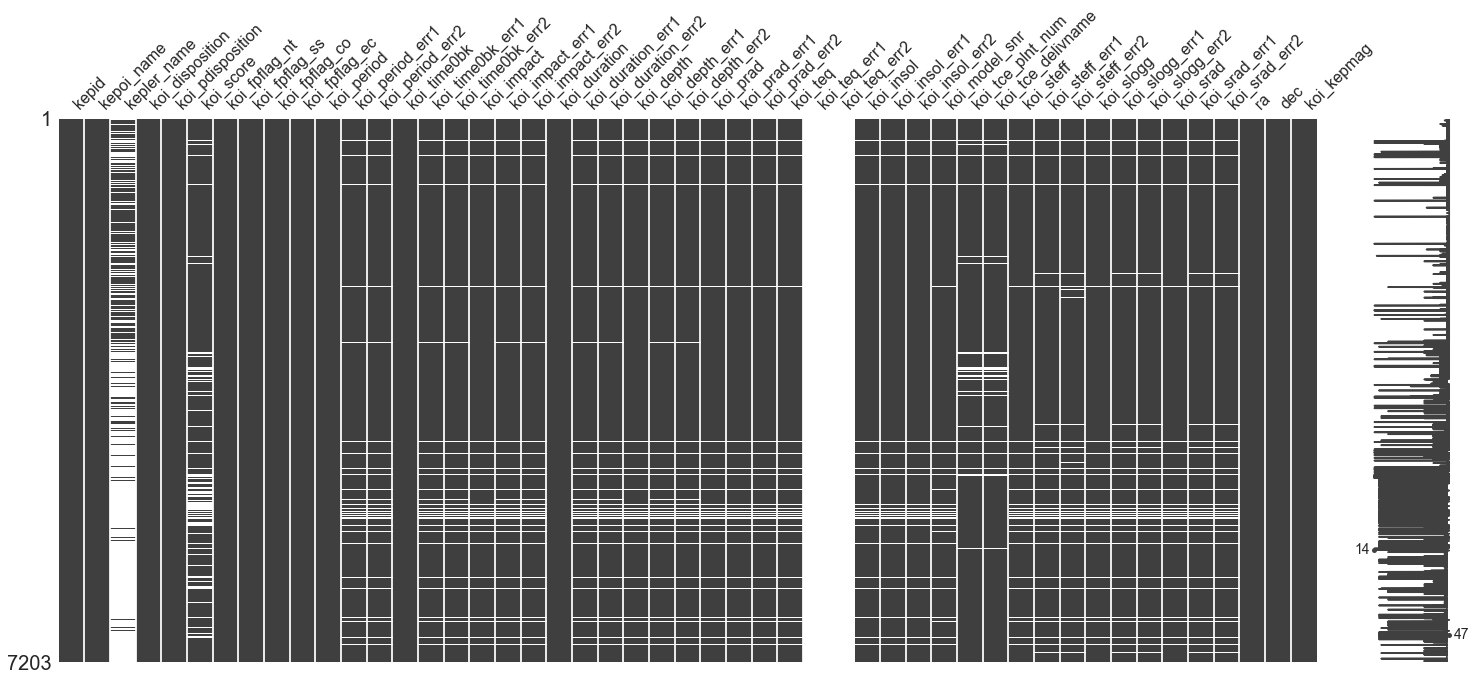

In [9]:
msno.matrix(subset_df)
# white indicates missing data

### Handling missing Data

In [10]:
# remove columns with more than 40% missing data
def remove_missing(f):
    count = len(df[df[f].isnull()])
    if count/len(df) > 0.4:
        return 1
    else:
        return 0

missing_values = [x for x in subset_df.columns if remove_missing(x)]
subset_df = subset_df.drop(missing_values, axis=1)

subset_df = subset_df.dropna()

<AxesSubplot:>

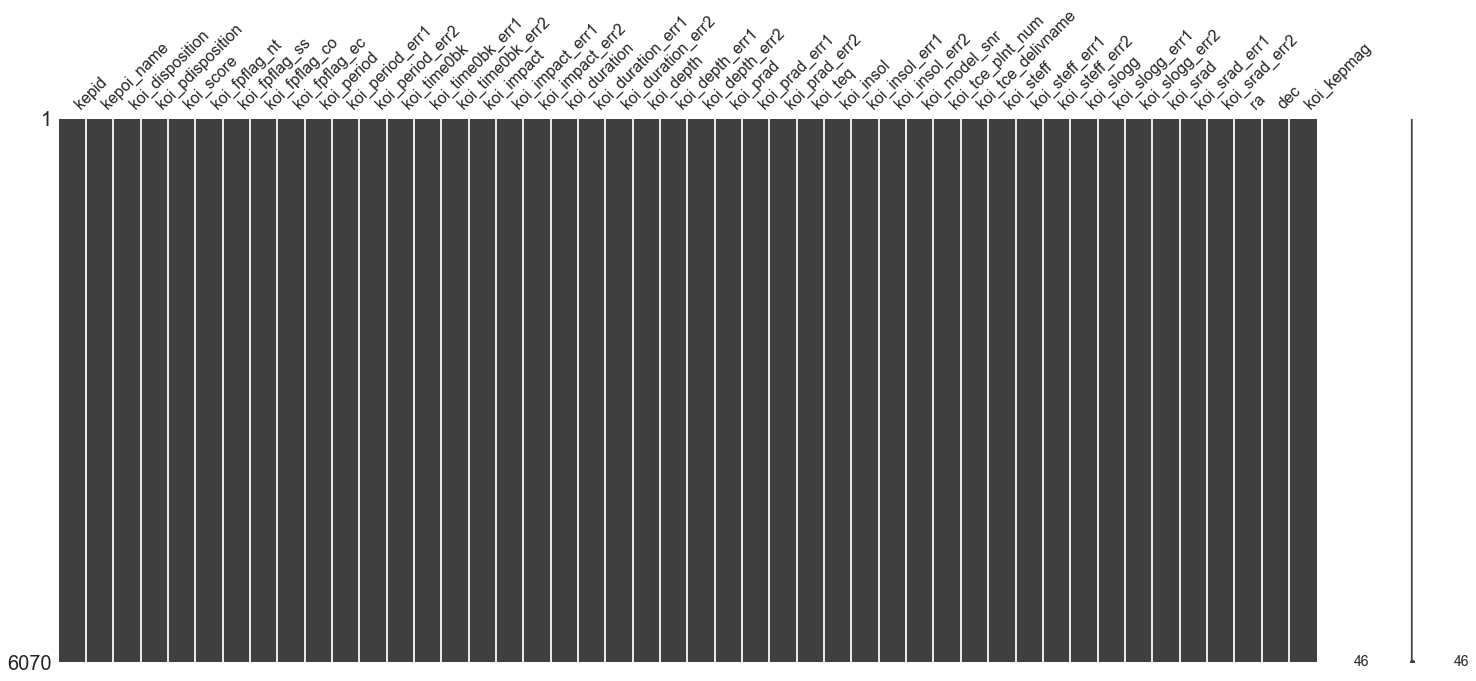

In [11]:
msno.matrix(subset_df)

### Obtaining X and y
     
     We can encode the categorical labels to 1 and 0 for easier comparison

    CONFIRMED - 1
    FALSE POSITIVE - 0



In [12]:
X = subset_df[TO_USE].values
y = subset_df["koi_disposition"].apply(lambda x: x=='CONFIRMED').astype(int).values

In [13]:
subset_df["koi_disposition"].value_counts()

FALSE POSITIVE    3735
CONFIRMED         2335
Name: koi_disposition, dtype: int64

### Data Visualization

In [14]:
def getVisualisationPCA(X, y):
    x = StandardScaler().fit_transform(X)
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(x)
    
    pca_df = pd.DataFrame(
        data = principal_components,
        columns = ['principal component 1', 'principal component 2']
    )
    
    pca_df["TARGET"] = y
    labels = np.unique(y)
    labels = ["CONFIRMED" if i ==1 else "FALSE POSITIVE" for i in labels]
    pca_df["TARGET"] = ["CONFIRMED" if i ==1 else "FALSE POSITIVE" for i in pca_df["TARGET"].values]
    plt.grid()
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, color in zip(labels, colors):
        indicesToKeep = pca_df['TARGET'] == label
        plt.scatter(
            pca_df.loc[indicesToKeep, 'principal component 1'],
            pca_df.loc[indicesToKeep, 'principal component 2'],
            c = color,
            label=label
        )
        
    plt.legend()
    plt.grid()
    plt.savefig("pca.png", dpi=600)
    
def getVarianceContribution(X, y):
    cols = X.shape[1]
    x = StandardScaler().fit_transform(X)
    pca = PCA().fit(x)
    variance = pca.explained_variance_ratio_
    s = np.sum(variance)
    p = variance/s
    plt.grid()
    plt.bar(list(range(1, cols+1)), p)
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.savefig("variance.png", dpi=600)
    plt.show()
    
    
def getFeatureCorrelation(X, y):
    visualizer = FeatureCorrelation(labels=TO_USE)
    visualizer.fit(X, y)
    #visualizer.show("correlation.png", dpi=600)
    
    
def getPearsonRanking(X):
    #visualizer = rank2d(X, features=TO_USE)
    visualizer = Rank2D(algorithm='pearson', features=TO_USE)
    visualizer.fit(X, y)           
    visualizer.transform(X)        
    #visualizer.show(outpath="pearson_ranking.png", dpi=600)
    

def getRadialViz(X, y):
    visualizer = RadViz(classes=[0, 1], features = TO_USE)
    visualizer.fit(X, y)           
    visualizer.transform(X)        
    #visualizer.show("radial.png", dpi=600)

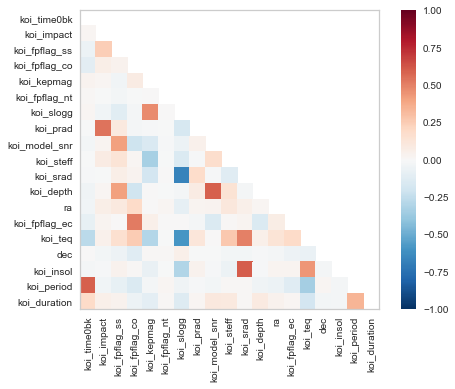

In [15]:
getPearsonRanking(X)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


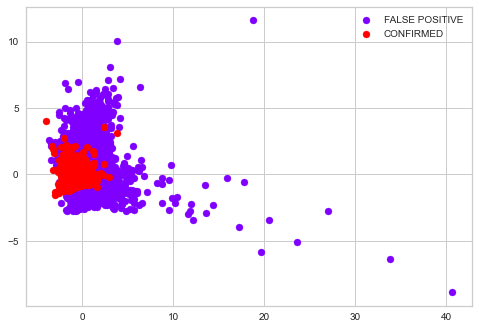

In [16]:
getVisualisationPCA(X, y)

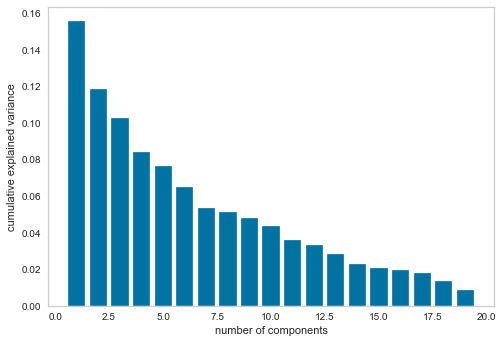

In [17]:
getVarianceContribution(X, y)

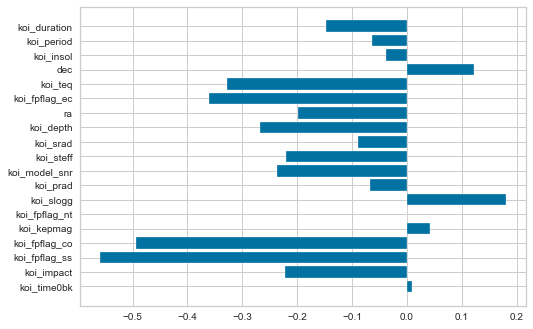

In [18]:
getFeatureCorrelation(X, y)

    * We can see that our columns are not interdependent and we can use all our columns
    
    * We observe that the two classes are not linearly separable, hence a simple Logistic Regression classifier will
    not do well.
    
    * Most important, we see there is a class imbalance present, hence we cannot go on accuracy scores and will need to compare scores for prediction across both classes - F1 scores and balanced accuracy scores

We need to hence using different techniques of non-linear classification, which can handle the non-linearity issue as well as class imbalance. We can employ Bagging or Boosting Techniques such as

    * SVM
    * Random Forests
    * AdaBoost



### Splitting into Train and Test sets

In [19]:
X = StandardScaler().fit_transform(X)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0, stratify=y)

In [21]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4066, 19), (2004, 19), (4066,), (2004,))

In [22]:
# List to contain model and accuracy values
eva_list = []
# to contain model names
models =[]

## ML Algorithms

### Logistic Regression

In [23]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

lr_acc = round(lr.score(X_train, y_train) * 100, 2)
lr_acc_test = round(accuracy_score(y_test, y_pred) * 100, 2)
print(f'Train Accuracy of Logistic Regression: % {lr_acc}')
print(f'Test Accuracy of Logistic Regression: % {lr_acc_test}')

# Get precision, recall, and f1
precision, recall, f1, support = score(y_test, y_pred, average = 'macro')
print(f'Precision : {precision}')
print(f'Recall : {recall}')
print(f'F1-score : {f1}')

Train Accuracy of Logistic Regression: % 97.22
Test Accuracy of Logistic Regression: % 97.16
Precision : 0.9676237145994875
Recall : 0.9729977499439852
F1-score : 0.9701368375342838


In [24]:
# Add performance parameters to list
eva_list.append(dict([
    ('Model', 'Logistic Regression'),
    ('Train Accuracy', round(lr_acc, 2)),
    ('Test Accuracy', round(lr_acc_test, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1, 2))
     ]))

### KNN

In [25]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

knn_acc = round(knn.score(X_train, y_train) * 100, 2)
knn_acc_test = round(accuracy_score(y_test, y_pred) * 100, 2)
print(f'Train Accuracy of KNN: % {knn_acc}')
print(f'Test Accuracy of KNN: % {knn_acc_test}')

# Get precision, recall, and f1
precision, recall, f1, support = score(y_test, y_pred, average = 'macro')
print(f'Precision : {precision}')
print(f'Recall : {recall}')
print(f'F1-score : {f1}')

Train Accuracy of KNN: % 97.39
Test Accuracy of KNN: % 97.01
Precision : 0.9661407369258861
Recall : 0.9712952180787109
F1-score : 0.9685578995923824


In [26]:
# Add performance parameters to list
eva_list.append(dict([
    ('Model', 'KNN'),
    ('Train Accuracy', round(knn_acc, 2)),
    ('Test Accuracy', round(knn_acc_test, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1, 2))
     ]))

### Naive Bayes

In [27]:
nbg = GaussianNB()
nbg.fit(X_train, y_train)
y_pred = nbg.predict(X_test)

nbg_acc=round(nbg.score(X_train, y_train) * 100, 2)
nbg_acc_test=round(accuracy_score(y_test, y_pred) * 100, 2)

print(f'Train Accuracy Score of GaussianNB: % {nbg_acc}')
print(f'Test Accuracy Score of GaussianNB: % {nbg_acc_test}')

# Get precision, recall, f1 scores
precision, recall, f1, support = score(y_test, y_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F1-score   : {f1}')

Train Accuracy Score of GaussianNB: % 95.72
Test Accuracy Score of GaussianNB: % 96.21
Precision : 0.9558486468271865
Recall    : 0.9667509254262641
F1-score   : 0.9604526404894085


In [28]:
# Add performance parameters to list
eva_list.append(dict([
    ('Model', 'GaussianNB'),
    ('Train Accuracy', round(nbg_acc, 2)),
    ('Test Accuracy', round(nbg_acc_test, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1, 2))
     ]))

### Decision Trees

In [29]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

dt_acc = round(dt.score(X_train, y_train) * 100, 2)
dt_acc_test = round(accuracy_score(y_test, y_pred) * 100, 2)
print(f'Train Accuracy Score of Decision Trees: % {dt_acc}')
print(f'Test Accuracy Score of Decision Trees: % {dt_acc_test}')

# Get precision, recall, f1 scores
precision, recall, f1, support = score(y_test, y_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F1-score   : {f1}')

Train Accuracy Score of Decision Trees: % 100.0
Test Accuracy Score of Decision Trees: % 99.45
Precision : 0.9948107576863213
Recall    : 0.9935953875429577
F1-score   : 0.9941957810142217


In [30]:
# Add performance parameters to list
eva_list.append(dict([
    ('Model', 'Decision Trees'),
    ('Train Accuracy', round(dt_acc, 2)),
    ('Test Accuracy', round(dt_acc_test, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1, 2))
     ]))

In [31]:
# View feature importances
importances_dt = pd.DataFrame({'feature': subset_df[TO_USE].columns,
                             'importance': dt.feature_importances_})
importances_dt = importances_dt.sort_values('importance',ascending=False).set_index('feature')
importances_dt.head(10)

,importance
feature,
koi_fpflag_co,0.339602
koi_fpflag_ss,0.304632
koi_fpflag_nt,0.278854
koi_fpflag_ec,0.067611
koi_model_snr,0.002074
koi_duration,0.002061
koi_time0bk,0.002057
koi_impact,0.001152
koi_kepmag,0.000693


### Random Forest

In [32]:
num_estimator = 100
seed = 7
rf = RandomForestClassifier(n_estimators=num_estimator)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

rf_acc = round(rf.score(X_train, y_train) * 100, 2)
rf_acc_test = round(accuracy_score(y_test, y_pred) * 100, 2)
print(f'Train Accuracy Score of Random Forest: % {rf_acc}')
print(f'Test Accuracy Score of Random Forest: % {rf_acc_test}')

# Get precision, recall, f1 scores
precision, recall, f1, support = score(y_test, y_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F1-score   : {f1}')

Train Accuracy Score of Random Forest: % 100.0
Test Accuracy Score of Random Forest: % 99.45
Precision : 0.9955787781350482
Recall    : 0.9928664072632944
F1-score   : 0.9941871488102034


In [33]:
# Add performance parameters to list
eva_list.append(dict([
    ('Model', 'Random Forest'),
    ('Train Accuracy', round(rf_acc, 2)),
    ('Test Accuracy', round(rf_acc_test, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1, 2))
     ]))

In [34]:
# View feature importances
importances_rf = pd.DataFrame({'feature': subset_df[TO_USE].columns,
                             'importance': rf.feature_importances_})
importances_rf = importances_rf.sort_values('importance',ascending=False).set_index('feature')
importances_rf.head(10)

,importance
feature,
koi_fpflag_co,0.190939
koi_fpflag_ss,0.149626
koi_prad,0.133453
koi_fpflag_nt,0.097987
koi_fpflag_ec,0.086915
koi_model_snr,0.054886
koi_depth,0.054174
koi_period,0.049847
koi_teq,0.037317


### Bagging Classifier

In [35]:
bag = BaggingClassifier(base_estimator=rf, n_estimators=num_estimator,
    bootstrap=True, n_jobs=-1, random_state=seed)

bag.fit(X_train, y_train)
y_pred = bag.predict(X_test)

bag_acc = round(bag.score(X_train, y_train) * 100, 2)
bag_acc_test = round(accuracy_score(y_test, y_pred) * 100, 2)

print(f'Train Accuracy Score of Bagged Classifier: % {bag_acc}')
print(f'Test Accuracy Score of Bagged Classifier: % {bag_acc_test}')

# Get precision, recall, f1 scores
precision, recall, f1, support = score(y_test, y_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F1-score   : {f1}')

Train Accuracy Score of Bagged Classifier: % 99.85
Test Accuracy Score of Bagged Classifier: % 99.55
Precision : 0.9963768115942029
Recall    : 0.9941634241245136
F1-score   : 0.9952463974381782


In [36]:
# Add performance parameters to list
eva_list.append(dict([
    ('Model', 'Bagging Classifier'),
    ('Train Accuracy', round(bag_acc, 2)),
    ('Test Accuracy', round(bag_acc_test, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1, 2))
     ]))

### Results

In [37]:
results = pd.DataFrame(data=eva_list)
results = results[['Model', 'Train Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1']]
results = results.sort_values(by='Test Accuracy', ascending=False)
results = results.set_index('Model')
results

,Train Accuracy,Test Accuracy,Precision,Recall,F1
Model,,,,,
Bagging Classifier,99.85,99.55,1.00,0.99,1.00
Decision Trees,100.00,99.45,0.99,0.99,0.99
Random Forest,100.00,99.45,1.00,0.99,0.99
Logistic Regression,97.22,97.16,0.97,0.97,0.97
KNN,97.39,97.01,0.97,0.97,0.97
GaussianNB,95.72,96.21,0.96,0.97,0.96


### Confusion Matrix 

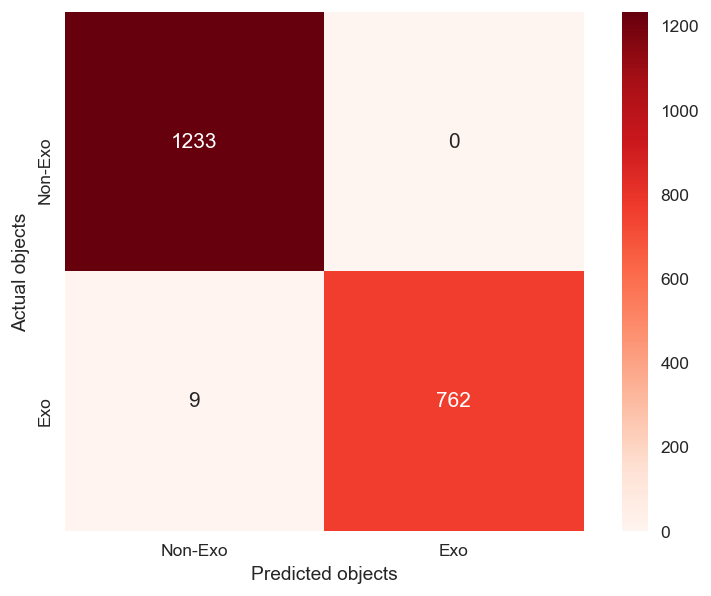

In [38]:
conf_mtrx = confusion_matrix(y_test, y_pred)
plt.figure(dpi=125)
sns.heatmap(conf_mtrx, cmap=plt.cm.Reds, annot=True, square=True,fmt='d',
           xticklabels=['Non-Exo', 'Exo'],
           yticklabels=['Non-Exo', 'Exo'])

plt.xlabel('Predicted objects')
plt.ylabel('Actual objects');

In [39]:
# saving model
pickle.dump(rf, open("rf_model.pkl","wb"))

***PRAKHAR_VARSHNEY***